## Weekend movie trip
### Blockbuster or art film?
1. Set up a data science project structure in a new git repository in your GitHub account
2. Download the one of the MovieLens datasets from https://grouplens.org/datasets/movielens/
3. Load the data set into panda data frames
4. Formulate one or two ideas on how the combination of ratings and tags by users helps the data set to establish additional value using exploratory data analysis
5. Build one or more clustering models to determine similar movies to recommend using the other ratings and tags of movies by other users as features
6. Document your process and results
7. Commit your notebook, source code, visualizations and other supporting files to the git repository in GitHub

In [1]:
#importing the required libraries
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
import nltk
import matplotlib.pyplot as plt
nltk.download('stopwords')

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

from joblib import dump, load
np.random.seed(6)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/santoshkhatiwada/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Lets read the necessary csv files like movie, rating and tags.

In [2]:
dfMovies = pd.read_csv('../data/ml-latest/movies.csv')
dfMovies.head(10)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
5,6,Heat (1995),Action|Crime|Thriller
6,7,Sabrina (1995),Comedy|Romance
7,8,Tom and Huck (1995),Adventure|Children
8,9,Sudden Death (1995),Action
9,10,GoldenEye (1995),Action|Adventure|Thriller


In [3]:
dfRating = pd.read_csv('../data/ml-latest/ratings.csv')
dfRating.head(10)

,userId,movieId,rating,timestamp
0,1,307,3.5,1256677221
1,1,481,3.5,1256677456
2,1,1091,1.5,1256677471
3,1,1257,4.5,1256677460
4,1,1449,4.5,1256677264
5,1,1590,2.5,1256677236
6,1,1591,1.5,1256677475
7,1,2134,4.5,1256677464
8,1,2478,4.0,1256677239
9,1,2840,3.0,1256677500


In [4]:
dfTags = pd.read_csv('../data/ml-latest/tags.csv')
dfTags.head(10)


,userId,movieId,tag,timestamp
0,14,110,epic,1443148538
1,14,110,Medieval,1443148532
2,14,260,sci-fi,1442169410
3,14,260,space action,1442169421
4,14,318,imdb top 250,1442615195
5,14,318,justice,1442615192
6,14,480,Dinosaurs,1443148563
7,14,593,psychothriller,1444014286
8,14,1682,philosophy,1442615158
9,14,1682,surveillance,1442615167


Since, many users have given different ratings for the same movie, lets calculate the average of the rating and use it as feature.

In [5]:
dfFrmRating = dfRating.groupby('movieId')['rating'].mean().reset_index()


In [6]:
dfFrmRating.head(10)


,movieId,rating
0,1,3.886649
1,2,3.246583
2,3,3.173981
3,4,2.874540
4,5,3.077291
5,6,3.844211
6,7,3.371348
7,8,3.122482
8,9,3.007530
9,10,3.431633


We can join the movie dataframe and rating dataframe using the column movieId.

In [7]:
dfMoviesWithRatings = pd.merge(dfMovies, dfFrmRating, how='left', left_on=['movieId'], right_on=['movieId'])
dfMoviesWithRatings.head(10)

,movieId,title,genres,rating
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.886649
1,2,Jumanji (1995),Adventure|Children|Fantasy,3.246583
2,3,Grumpier Old Men (1995),Comedy|Romance,3.173981
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,2.874540
4,5,Father of the Bride Part II (1995),Comedy,3.077291
5,6,Heat (1995),Action|Crime|Thriller,3.844211
6,7,Sabrina (1995),Comedy|Romance,3.371348
7,8,Tom and Huck (1995),Adventure|Children,3.122482
8,9,Sudden Death (1995),Action,3.007530
9,10,GoldenEye (1995),Action|Adventure|Thriller,3.431633


As seen from the tags dataframe, one movie has multiple tags from different users. We can combine all the tags in same row for each movie.

In [8]:
def tags(tag):
    totaltags = []
    for index, value in tag.iteritems():
        if(type(value)==str):
            totaltags.append(value)
    return '|'.join(totaltags)

selectedDfTags = dfTags
tags = (selectedDfTags.groupby('movieId')['tag'].apply(lambda x: tags(x)).reset_index())

tags.sort_values(by='movieId', ascending=True).head(10)

,movieId,tag
0,1,animated|buddy movie|Cartoon|cgi|comedy|comput...
1,2,fantasy|adapted from:book|animals|bad cgi|base...
2,3,moldy|old|Ann Margaret|Burgess Meredith|Daryl ...
3,4,characters|girl movie|characters|chick flick|b...
4,5,steve martin|steve martin|pregnancy|remake|agi...
5,6,overrated|bank robbery|crime|heists|relationsh...
6,7,Greg Kinnear|romance|Greg Kinnear|romance|base...
7,8,Disney|Library System|based on a book|Mark Twa...
8,9,Jean-Claude Van Damme|explosive|hostage|terror...
9,10,007|James Bond|Pierce Brosnan|Bob*ola|MTSKAF|b...


We can combine the tags dataframe to the previous merged dataframe by using the same column movieId.

In [9]:
dfMoviesRatingTags = pd.merge(dfMoviesWithRatings, tags, how='left', left_on=['movieId'], right_on=['movieId'])
dfMoviesRatingTags = dfMoviesRatingTags.dropna()
dfMoviesRatingTags.head(10)

,movieId,title,genres,rating,tag
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.886649,animated|buddy movie|Cartoon|cgi|comedy|comput...
1,2,Jumanji (1995),Adventure|Children|Fantasy,3.246583,fantasy|adapted from:book|animals|bad cgi|base...
2,3,Grumpier Old Men (1995),Comedy|Romance,3.173981,moldy|old|Ann Margaret|Burgess Meredith|Daryl ...
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,2.874540,characters|girl movie|characters|chick flick|b...
4,5,Father of the Bride Part II (1995),Comedy,3.077291,steve martin|steve martin|pregnancy|remake|agi...
5,6,Heat (1995),Action|Crime|Thriller,3.844211,overrated|bank robbery|crime|heists|relationsh...
6,7,Sabrina (1995),Comedy|Romance,3.371348,Greg Kinnear|romance|Greg Kinnear|romance|base...
7,8,Tom and Huck (1995),Adventure|Children,3.122482,Disney|Library System|based on a book|Mark Twa...
8,9,Sudden Death (1995),Action,3.007530,Jean-Claude Van Damme|explosive|hostage|terror...
9,10,GoldenEye (1995),Action|Adventure|Thriller,3.431633,007|James Bond|Pierce Brosnan|Bob*ola|MTSKAF|b...


Now we want to use tags for clustering the movies. However, the tags include long sentences with stop words as well. So, we will use CountVectorizer which will convert the 'tag' column to the vector of words. Since we have large dimension of data, we take the top 500 frequent token of tags.

In [10]:
stop_words = stopwords.words('english')
cntVectorizer = CountVectorizer(binary=True, stop_words=stop_words, min_df=5, max_df=0.99,max_features=500)
#cntVectorizer = TfidfVectorizer(binary=False, stop_words=stop_words, min_df=5, max_df=0.99,max_features=500)
data = cntVectorizer.fit_transform(dfMoviesRatingTags['tag'])#fit makes a dictionary and transform 
                                                            #the words into values of dictionary.
vocab = cntVectorizer.get_feature_names()

features = data

For dimensionality reduction and converting categorical data to numbers, we use PCA. We compress 500 tokens to 50 principal components.

In [11]:
pca = PCA(n_components=50, random_state=6)
principalComponents = pca.fit_transform(data.toarray())

Now, we add the ratings to  the array principalComponents for the clustering.

In [12]:
pcaWithRating = np.column_stack((principalComponents, dfMoviesRatingTags['rating'].values))
pcaWithRating.shape

(41772, 51)

Before applying clustering algorithm, we want to check how all movies are clustered in a 2 dimensional space based on first two principal components.

Text(0,0.5,'PCA 2')

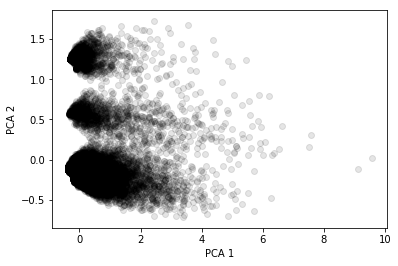

In [13]:
plt.scatter(pcaWithRating[:,0], pcaWithRating[:,1], alpha=.1, color='black')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

Based on the 2 components, we obtain some clusters in the scatter plot. Now we are going to use KMeans model for clustering and inorder to select the hyperparameter k, we will use inertia as a metric.

In [14]:
ks = range(3, 15)
inertiaList = []
for k in ks:
    kmeansModel = KMeans(n_clusters=k,random_state=6,max_iter=50,tol=0.01)
    kmeansModel.fit(pcaWithRating) 
    inertiaList.append(kmeansModel.inertia_)



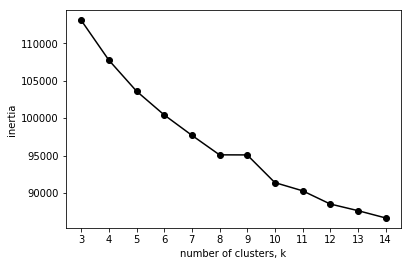

In [15]:
plt.plot(ks, inertiaList, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

As seen in the graph above,  12 seems to be the good value.

In [16]:
kmeansModel = KMeans(n_clusters=12,random_state=6,verbose=0,max_iter=50,tol=0.001)
kmeansModel.fit(pcaWithRating)

dump(kmeansModel, '../models/kmeans.joblib')

['../models/kmeans.joblib']

Now, lets obtain the prediction for the features.

In [17]:
loadedModel = load('../models/kmeans.joblib')
clusters = loadedModel.predict(pcaWithRating)
clusters

array([ 5,  4,  7, ...,  1, 10,  7], dtype=int32)

We are going to join the cluster back to the main dataframe.

In [18]:
dfMoviesRatingTags['cluster'] = clusters
dfMoviesRatingTags = dfMoviesRatingTags.reset_index()

lets view some of the movie of cluster 0.

In [19]:
dfMoviesRatingTags[dfMoviesRatingTags['cluster']==0].head(10)

,index,movieId,title,genres,rating,tag,cluster
6,6,7,Sabrina (1995),Comedy|Romance,3.371348,Greg Kinnear|romance|Greg Kinnear|romance|base...,0
10,10,11,"American President, The (1995)",Comedy|Drama|Romance,3.660278,president|Annette Bening|ethics|great cast|gre...,0
13,13,14,Nixon (1995),Drama,3.429000,Anthony Hopkins|Drama|biographical|based on a ...,0
35,35,36,Dead Man Walking (1995),Crime|Drama,3.928762,death penalty|death penalty|Nun|prison|Sean Pe...,0
55,57,58,"Postman, The (Postino, Il) (1994)",Comedy|Drama|Romance,3.964110,italian love story|poetry|writing|fisherman|is...,0
109,114,116,Anne Frank Remembered (1995),Documentary,3.914914,germany|Glenn Close|holocaust|jews|nazis|Oscar...,0
110,115,117,"Young Poisoner's Handbook, The (1995)",Crime|Drama,3.587900,to see|disturbing|based on a true story|london...,0
114,119,121,"Boys of St. Vincent, The (1992)",Drama,3.735772,sexual abuse|To See|child abuse|1970s|Catholic...,0
116,121,123,Chungking Express (Chung Hing sam lam) (1994),Drama|Mystery|Romance,3.988311,amelie-esque|stylized|very good|wong kar wai|d...,0
138,145,147,"Basketball Diaries, The (1995)",Drama,3.601513,drugs|intense|addiction|drugs|intense|Leonardo...,0


In [20]:
avgRatingPerCluster = dfMoviesRatingTags.groupby('cluster').agg({'rating':['count','mean']}).reset_index()
avgRatingPerCluster

cluster rating          
            count      mean
0        0    883  3.460251
1        1   3965  1.692114
2        2   1773  3.033530
3        3   2165  3.175440
4        4   2081  3.261297
5        5    986  3.732238
6        6   9314  3.694162
7        7   2009  3.278327
8        8   3094  3.225623
9        9   2825  3.278732
10      10  11288  2.862029
11      11   1389  3.352620

Text(0,0.5,'PCA 2')

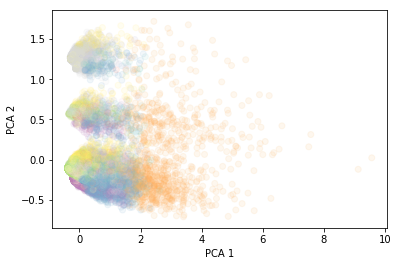

In [21]:
plt.scatter(pcaWithRating[:,0], pcaWithRating[:,1], alpha=.1, c=dfMoviesRatingTags['cluster'].values, cmap=plt.cm.Set3)

plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

We can see different colored clusters and overlapping between them when seen on 2D and some of the data are seen as outliers.

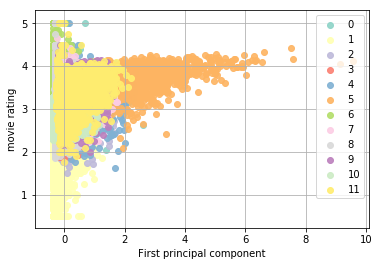

In [22]:
set3Colors = list(plt.cm.Set3.colors)

fig, ax = plt.subplots()
for key,color in enumerate(set3Colors):
    indices = dfMoviesRatingTags[dfMoviesRatingTags['cluster']==key].index
    ax.scatter(pcaWithRating[indices,0], pcaWithRating[indices,50],  c=set3Colors[key], label=key,
               alpha=0.9)
    

ax.legend()
ax.grid(True)
plt.xlabel('First principal component')
plt.ylabel('movie rating')
plt.show()

We plotted the cluster of movies based on first principal component and movie rating. We can see some clusters although some overlapping takes place which may be due to projection on 2D.

Lets see what happens on 3D.

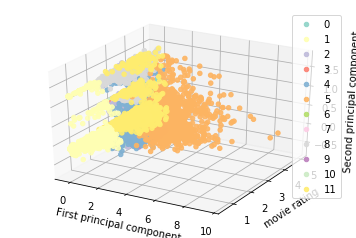

In [23]:
ax = plt.subplot(111, projection='3d')
for key,color in enumerate(set3Colors):
    indices = dfMoviesRatingTags[dfMoviesRatingTags['cluster']==key].index
    ax.scatter(pcaWithRating[indices,0], pcaWithRating[indices,50], pcaWithRating[indices,1],  
               c=set3Colors[key], label=key,
               alpha=0.9)
    

ax.legend()
ax.grid(True)
ax.set_xlabel('First principal component')
ax.set_ylabel('movie rating')
ax.set_zlabel('Second principal component')
plt.show()

On 3D, the some points which were supposed to be outliers are also seen in clusters. Now lets see the significant tags which may be responsible for clustering the movies.

In [24]:
vocabArray = np.array(vocab)
for i in range(12):
    indices = dfMoviesRatingTags[dfMoviesRatingTags['cluster']==i].index
    cluster = features[indices]
    clusterColumnSum = cluster.sum(axis=0)
    clusterToArray = np.squeeze(np.asarray(clusterColumnSum))
    positiveIndex = np.argsort(-1*clusterToArray)[0:10]
    print("top 10 tags for cluster {}:{}" .format(i,vocabArray[positiveIndex]))

top 10 tags for cluster 0:['story' 'true' 'based' 'biography' 'war' 'drama' 'book' 'history' 'movie'
 'world']
top 10 tags for cluster 1:['movie' 'film' 'murder' 'bad' 'woman' 'bd' 'horror' 'comedy' 'sequel'
 'monster']
top 10 tags for cluster 2:['nudity' 'topless' 'frontal' 'full' 'sex' 'notable' 'murder' 'film'
 'brief' 'movie']
top 10 tags for cluster 3:['film' 'independent' 'silent' 'cult' 'movie' 'noir' 'murder' 'short'
 'dvd' 'new']
top 10 tags for cluster 4:['based' 'book' 'novel' 'adapted' 'author' 'bd' 'movie' 'war' 'love'
 'film']
top 10 tags for cluster 5:['dvds' 'movie' 'best' 'bd' 'good' 'video' 'dvd' 'seen' 'see' 'great']
top 10 tags for cluster 6:['war' 'documentary' 'movie' 'love' 'music' 'short' 'drama' 'murder'
 'family' 'new']
top 10 tags for cluster 7:['comedy' 'funny' 'stand' 'dark' 'movie' 'black' 'romance' 'humor'
 'romantic' 'family']
top 10 tags for cluster 8:['director' 'woman' 'film' 'female' 'independent' 'relationship' 'love'
 'family' 'new' 'documentary']


As seen from the tags above, cluster 5 may contain oscar nominated movies because of the tags like best, great, etc. We can have a look for this.

In [28]:
dfMoviesRatingTags[dfMoviesRatingTags['cluster']==5].tail(15)

,index,movieId,title,genres,rating,tag,cluster
28900,34855,140956,Ready Player One,Action|Sci-Fi|Thriller,3.654299,romance|1980s|80s video games|action|avatars|d...,5
30719,38102,148626,"Big Short, The (2015)",Drama,4.019956,actor talks to audience|documentary|speculatio...,5
31488,39494,152081,Zootopia (2016),Action|Adventure|Animation|Children|Comedy,3.933741,acceptance|cute|police|racism|social commentar...,5
34453,44809,164179,Arrival (2016),Sci-Fi,4.019926,alien|alien contact|Aliens|Amy Adams|based on ...,5
34653,45140,164909,La La Land (2016),Comedy|Drama|Romance,3.751384,bad music|bad script|colour|Emma Stone|love st...,5
34835,45439,165549,Manchester by the Sea (2016),Drama,3.848823,blue collar|death|depression|funeral|grief|hea...,5
35124,45864,166528,Rogue One: A Star Wars Story (2016),Action|Adventure|Fantasy|Sci-Fi,3.824173,aliens|sci-fi|space|space travel|original|Star...,5
35164,45915,166635,Passengers (2016),Adventure|Drama|Romance|Sci-Fi,3.537236,Predictable|Romance|Space|Predictable|Visually...,5
35616,46662,168250,Get Out (2017),Horror,3.951563,Hypnotism|mind control|Disturbing|Bingo|Hypnot...,5
37327,49412,174055,Dunkirk (2017),Action|Drama|Thriller|War,3.799126,Boring|Christopher Nolan|history|Writer: Chris...,5


Based on the choice of features, dimensionality reduction, and behaviour of KMeans clustering algorithm, some clusters contain more number of movies although the significant tags are related.

In [29]:
dfMoviesRatingTags[dfMoviesRatingTags['cluster']==4].tail(10)

,index,movieId,title,genres,rating,tag,cluster
41436,56568,189845,National Theatre Live: The Curious Incident of...,(no genres listed),4.000000,live performance|Based on a book|Mystery|Natio...,4
41470,56676,190165,Severus Snape and the Marauders (2016),Adventure|Drama|Fantasy|Mystery,3.500000,based on a book|dual|fan film|fantasy|harry po...,4
41471,56685,190183,The Darkest Minds (2018),Sci-Fi|Thriller,2.826087,Adolescents|Based on book|Mind power|Super pow...,4
41492,56750,190339,White Fang (2018),Animation|Drama,3.500000,based a book|based a novel|wolf|animal cruelty...,4
41509,56814,190519,Bécassine ! (2018),Comedy,3.000000,based on a comic book|brittany|france|nanny|slow,4
41555,56977,190939,A Simple Favor (2018),Crime|Mystery|Thriller,3.514286,Insurance scam|bassed on a book|prospect|Dark ...,4
41637,57358,191997,The Hounds of Baskerville (2012),Crime|Drama|Mystery,4.065789,based on book|bbc|Benedict Cumberbatch|british...,4
41638,57359,191999,The Reichenbach Fall (2012),Crime|Drama|Mystery,4.375000,based on book|bbc|Benedict Cumberbatch|british...,4
41682,57587,192559,The House with a Clock in Its Walls (2018),Children|Fantasy|Horror|Mystery|Sci-Fi|Thriller,3.272727,Evil Pumpkins|Hallowen|warlock|might like|adap...,4
41766,58023,193731,The Fencing Master (1992),Adventure|Thriller,3.000000,19th century|based on a book|conspiracy|femme ...,4


In cluster 4, most of the movies are clustered with 'book', 'novel' tag.